# Machine Learning - Project - Group MAA_202021_10
## Group Members
|Name|StudentID|
|:-----------:|:--------:|
|Fabio Lopes|20200597|
|Filipe Costa|20201041|
|Jorge Pereira|20201085|

## Introduction 
Put some introduction here

## Package Instalation and Importing

In [1]:
#import sys
#!{sys.executable} -m pip install -U xlrd
#!{sys.executable} -m pip install -U xgboost
#!{sys.executable} -m pip install -U hyperopt
#!{sys.executable} -m pip install -U mlflow
#!{sys.executable} -m pip install -U imbalanced-learn
#!{sys.executable} -m pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import time

from sklearn.model_selection import train_test_split, cross_val_score,cross_validate
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, auc, classification_report, confusion_matrix
from sklearn.feature_selection import SelectFromModel

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import CondensedNearestNeighbour, RandomUnderSampler

from xgboost import XGBClassifier

import matplotlib.pyplot as plt

from collections import Counter

In [3]:
data = pd.read_excel('Train.xlsx')
data_test = pd.read_excel("Test.xlsx")

In [4]:
print(f"Training data has {data.shape[1]} columns and {data.shape[0]} rows.")

Training data has 15 columns and 22400 rows.


## Data Cleansing & Feature Engineering Functions
In this section, we will define the Cleansing functions

In [5]:
def strip_lower(df):
    """Detects the String columns and converts all the records to lowercase."""
    for column in df.columns:
        if df[column].dtype == 'object':
            df[column] = df[column].apply(str.strip).apply(str.lower)
    return df

In [6]:
def fill_missing_values(df,ColumnswithMissingValues):
    for column in ColumnswithMissingValues:
        ColumnMode = df[column].mode()[0]
        df[column] = df[column].str.replace('?',ColumnMode, regex=False)
    return df

In [7]:
def ComputeAgeAt2048(Birthday):
    CurrentYear=datetime(2048,1,1)
    
    s_YearOfBirth = Birthday.split(",")[1]
    YearOfBirth = datetime(int(s_YearOfBirth),1,1)
        
    return CurrentYear.year - YearOfBirth.year

In [8]:
def ClassifyCitizen(Difference):
    if Difference == 0:
        return 'A' # Chosen carefully from volunteers
    elif Difference > 0:
        return 'B' # Invited
    elif Difference < 0:
        return 'C' # Paid

In [9]:
def encode_data(data, nominal_variables):
    data_Encoded = data.copy()
    dummies = pd.get_dummies(data_Encoded[nominal_variables], prefix=nominal_variables)
    data_Encoded = pd.concat([data_Encoded,dummies],axis=1)
    data_Encoded = data_Encoded.drop(nominal_variables, axis =1)
    return data_Encoded

In [10]:
def AlignDataframe(ColumnsInModel,df):
    dummy_df = pd.DataFrame(columns=ColumnsInModel)
    dummy_df, aligned_df = dummy_df.align(df,fill_value=0,join='left',axis=1)
    return aligned_df

In [11]:
def MaritalStatusNormalization(Mstatus):
    if Mstatus == 'married':
        return 'married'
    elif Mstatus == 'single':
        return 'not_married'
    elif Mstatus == 'divorced':
        return 'not_married'
    elif Mstatus == 'separated':
        return 'not_married'
    elif Mstatus == 'widow':
        return 'not_married'
    elif Mstatus == 'married - spouse missing':
        return 'married'
    elif Mstatus == 'married - spouse in the army':
        return 'married'
    else:
        return 'NA'

In [12]:
def LivesWithNormalization(Lwith):
    if Lwith == 'wife':
        return 'spouse'
    elif Lwith == 'other family':
        return 'other'
    elif Lwith == 'children':
        return 'children'
    elif Lwith == 'alone':
        return 'alone'
    elif Lwith == 'husband':
        return 'spouse'
    elif Lwith == 'other relatives':
        return 'other'
    else:
        return 'NA'

In [13]:
def Sector(S):
    if S == 'private sector - services':
        return 'private'
    elif S == 'self-employed (individual)':
        return 'self'
    elif S == 'public sector - others':
        return 'public'
    elif S == 'private sector - others':
        return 'private'
    elif S == 'self-employed (company)':
        return 'self'
    elif S == 'public sector - government':
        return 'public'
    elif S == 'unemployed':
        return 'None'
    elif S == 'never worked':
        return 'None'
    else:
        return 'NA'

In [14]:
def DataPreProcessing(data):
    # Lowers all case in string variables
    new_df = data.copy()

    new_df = strip_lower(new_df)

    # Deals with missing values
    ColumnswithMissingValues = ['Role','Employment Sector','Base Area']
    new_df = fill_missing_values(new_df,ColumnswithMissingValues)

    # Computes Age
    new_df['Age'] = new_df['Birthday'].apply(ComputeAgeAt2048)
    new_df.drop('Birthday', axis=1, inplace=True)

    # Classifies Citizen
    new_df['Group'] = (new_df['Money Received'] - new_df['Ticket Price']).apply(ClassifyCitizen)

    # Marital Status Normalization
    new_df['MStatus'] = new_df['Marital Status'].apply(MaritalStatusNormalization)
    new_df.drop('Marital Status', axis=1, inplace=True)

    # Lives With Normalization
    new_df['Lwith'] = new_df['Lives with'].apply(LivesWithNormalization)
    new_df.drop('Lives with', axis=1, inplace=True)

    # Employment Sector Normalization
    new_df['Sector'] = new_df['Employment Sector'].apply(Sector)
    new_df.drop('Employment Sector', axis=1, inplace=True)

    # Creates Ordinal Variable from Education
    EducationClassification = {
                            "phd" : 16,
                            "masters + postgraduation" : 15,
                            "masters" : 14,
                            "bachelors + postgraduation" : 13,
                            "bachelors" : 12,
                            "professional school + postgraduation" : 11,
                            "high school + postgraduation" : 10,
                            "professional school" : 9,
                            "high school complete" : 8,
                            "high school - 2nd cycle" : 7,
                            "high school - 1st cycle" : 6,
                            "middle school complete" : 5,
                            "middle school - 2nd cycle" : 4,
                            "middle school - 1st cycle" : 3,
                            "primary school" : 2,
                            "preschool" : 1
                            }
    new_df['Education_Class'] = new_df['Education Level'].map(EducationClassification)
    new_df.drop('Education Level', axis=1, inplace=True)

    # Performs one hot encoding in nominal variables
    NominalVariables = ['Native Continent', 
                        'Role', 
                        'MStatus', 
                        'Lwith', 
                        'Sector', 
                        'Group']

    new_df = encode_data(new_df, NominalVariables)

    # Drops the Name column and selects Citizen ID as the index
    new_df = new_df.drop(['Name'], axis =1)
    new_df = new_df.drop(['Base Area'], axis =1)
    new_df.set_index(["CITIZEN_ID"],inplace=True)

    # Scale Data
#     if 'Income' in new_df.columns:
#         featuresToScale = new_df.columns.drop('Income')
#     else:
#         featuresToScale = new_df.columns
#     new_df = MinMaxScaler_df(new_df,featuresToScale)

    return new_df.copy()

In [15]:
processedTrainingData = DataPreProcessing(data)
processedTestingData = DataPreProcessing(data_test)

In [16]:
processedTrainingData.head(5)

,Years of Education,Working Hours per week,Money Received,Ticket Price,Income,Age,Education_Class,Native Continent_africa,Native Continent_america,Native Continent_asia,...,Lwith_children,Lwith_other,Lwith_spouse,Sector_None,Sector_private,Sector_public,Sector_self,Group_A,Group_B,Group_C
CITIZEN_ID,,,,,,,,,,,,,,,,,,,,,
12486,13,40,0,2273,1,45,10,0,0,0,...,0,0,1,0,1,0,0,0,0,1
12487,12,40,0,0,1,42,9,0,0,0,...,0,0,1,0,0,1,0,1,0,0
12488,12,46,0,2321,1,39,9,0,0,0,...,0,0,1,0,1,0,0,0,0,1
12489,11,37,5395,0,1,63,7,0,0,0,...,0,0,1,0,1,0,0,0,1,0
12490,21,45,0,0,1,33,16,0,0,0,...,0,1,0,0,0,0,1,1,0,0


## Model Creation
In this section, we will create the models.

In [17]:
def objective(space):
    classifier = xgb.XGBClassifier(n_estimators = space['n_estimators']
                                 , max_depth = int(space['max_depth'])
                                 , learning_rate = space['learning_rate']
                                 , gamma = space['gamma']
                                 , min_child_weight = space['min_child_weight']
                                 , subsample = space['subsample']
                                 , colsample_bytree = space['colsample_bytree'])
  
    classifier.fit(optimizer_X_train, optimizer_y_train)
    accuracies = cross_val_score(estimator = classifier, X = optimizer_X_train, y = optimizer_y_train, cv = 5, scoring = 'roc_auc')
    CrossValMean = accuracies.mean()
  
    return{'loss':1-CrossValMean, 'status': STATUS_OK }

In [18]:
def runModels(models,X,y,X_test,y_test):

    GlobalTimerStart = time.time()
    ModelPerf = []
    for model in models:
        print(f"Running Model: {type(model).__name__}")
        LocalTimerStart = time.time()
        model.fit(X,y)
        scoresf1w = cross_validate(model, X,y, cv=10,scoring=('f1_weighted'))
        labels_val = model.predict(X_test)
        ModelPerf.append((type(model).__name__,
                          'Train',
                          scoresf1w['test_score'].mean()
        ))
        ModelPerf.append((type(model).__name__,
          'Test',
          f1_score(y_test, labels_val, average='weighted')
        ))
        
        LocalTimerEnd = time.time()
        print(f"-- Done. Duration: {LocalTimerEnd-LocalTimerStart} s")
    GlobalTimerEnd = time.time()
    print(f"GLOBAL DURATION: {GlobalTimerEnd-GlobalTimerStart} s")
    
    res = pd.DataFrame(ModelPerf,columns=['model','Stage','f1weighted'])
    
    fig = plt.figure(figsize=(20, 10))
    graph = sns.barplot(x="model", y="f1weighted", hue="Stage", data=res)
    graph.legend(loc='lower left')
    for bar in graph.patches:
        graph.annotate(format(bar.get_height(), '.4f'), 
                       (bar.get_x() + bar.get_width() / 2., bar.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, -12),
                       color="white",
                       textcoords = 'offset points')

    graph.set_xticklabels(graph.get_xticklabels(),
                          rotation=45,
                          horizontalalignment='center',
                          fontweight='light')
    
    return res

### Correlation

In [19]:
corr_df = processedTrainingData[['Ticket Price','Working Hours per week', 'Money Received','Years of Education',
       'Ticket Price', 'Income', 'Age', 'Education_Class','Group_A', 'Group_B', 'Group_C']].corr()
corr_df

,Ticket Price,Working Hours per week,Money Received,Years of Education,Ticket Price,Income,Age,Education_Class,Group_A,Group_B,Group_C
Ticket Price,1.000000,0.052959,-0.031330,0.084810,1.000000,0.155890,0.055774,0.081762,-0.567060,-0.065122,0.980514
Working Hours per week,0.052959,1.000000,0.075471,0.138516,0.052959,0.219890,0.064900,0.144922,-0.092201,0.074887,0.048958
Money Received,-0.031330,0.075471,1.000000,0.123015,-0.031330,0.221440,0.072693,0.118556,-0.373136,0.481099,-0.031953
Years of Education,0.084810,0.138516,0.123015,1.000000,0.084810,0.333089,0.035241,0.984065,-0.142698,0.111686,0.081220
Ticket Price,1.000000,0.052959,-0.031330,0.084810,1.000000,0.155890,0.055774,0.081762,-0.567060,-0.065122,0.980514
Income,0.155890,0.219890,0.221440,0.333089,0.155890,1.000000,0.233157,0.330227,-0.305667,0.263008,0.143257
Age,0.055774,0.064900,0.072693,0.035241,0.055774,0.233157,1.000000,0.031290,-0.125038,0.115570,0.048285
Education_Class,0.081762,0.144922,0.118556,0.984065,0.081762,0.330227,0.031290,1.000000,-0.139703,0.110063,0.078583
Group_A,-0.567060,-0.092201,-0.373136,-0.142698,-0.567060,-0.305667,-0.125038,-0.139703,1.000000,-0.775591,-0.578330
Group_B,-0.065122,0.074887,0.481099,0.111686,-0.065122,0.263008,0.115570,0.110063,-0.775591,1.000000,-0.066417


In [20]:
corr_df = processedTrainingData[['Ticket Price','Working Hours per week', 'Money Received','Years of Education',
       'Ticket Price', 'Income', 'Age', 'Education_Class','Group_A', 'Group_B', 'Group_C']].corr()
corr_df
#High correlation between Ticket Price and Group_C. We can remove one of then
#Also high correlation between Years of Education and Education class
processedTrainingData = processedTrainingData.drop(['Group_C','Education_Class'],axis=1)

In [21]:
corr_df = processedTrainingData.corr()['Income']
low_corr_cols =[]
for col in list(corr_df.index):
    if(np.abs(corr_df[col]) < 0.1):
        low_corr_cols.append(col)

In [22]:
processedTrainingData = processedTrainingData.drop(low_corr_cols,axis=1)

### Outliers

In [23]:
#Outliers
Q1 = processedTrainingData.quantile(0.25)
Q3 = processedTrainingData.quantile(0.75)
IQR = Q3 - Q1
IQR = IQR[IQR > 0]
IQR

Years of Education         3.0
Working Hours per week     5.0
Age                       20.0
MStatus_married            1.0
MStatus_not_married        1.0
Lwith_other                1.0
Lwith_spouse               1.0
dtype: float64

In [24]:
IQR = IQR[['Years of Education','Working Hours per week','Age']]
processedTrainingData = processedTrainingData[~((processedTrainingData < (Q1 - 1.5 * IQR)) |(processedTrainingData > (Q3 + 1.5 * IQR))).any(axis=1)]

### Split Training Data

In [25]:
target = 'Income'

X = processedTrainingData[[x for x in processedTrainingData.columns if x != target]]
y = processedTrainingData[[x for x in processedTrainingData.columns if x == target]]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, stratify=y)

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

# MODEL DEFINITION

In [26]:
modellog = LogisticRegression(max_iter=1000000)
modelKNN = KNeighborsClassifier()
modelTree = DecisionTreeClassifier()
modelSVC = SVC()
modelNAB = GaussianNB()
modelRF = RandomForestClassifier()
modelGBC = GradientBoostingClassifier()
modelAda = AdaBoostClassifier()
modelMLP = MLPClassifier(max_iter=500)
modelLDA = LinearDiscriminantAnalysis()

# Run All Models, without over/under sampling and without scaling

Running Model: LogisticRegression
-- Done. Duration: 14.073698997497559 s
Running Model: KNeighborsClassifier
-- Done. Duration: 2.8414900302886963 s
Running Model: DecisionTreeClassifier
-- Done. Duration: 0.22813630104064941 s
Running Model: SVC
-- Done. Duration: 17.21634078025818 s
Running Model: GaussianNB
-- Done. Duration: 0.08094167709350586 s
Running Model: RandomForestClassifier
-- Done. Duration: 5.806615829467773 s
Running Model: GradientBoostingClassifier
-- Done. Duration: 5.707021713256836 s
Running Model: AdaBoostClassifier
-- Done. Duration: 2.3390953540802 s
Running Model: LinearDiscriminantAnalysis
-- Done. Duration: 0.2513902187347412 s
GLOBAL DURATION: 48.54612708091736 s


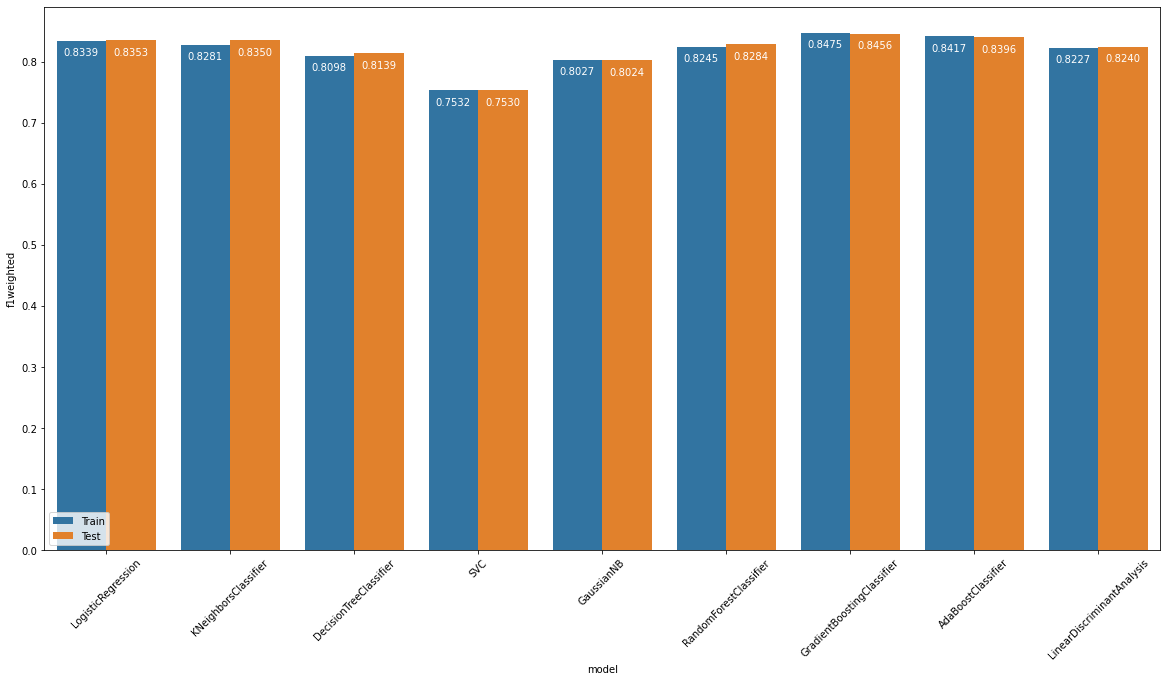

In [27]:
models = [  modellog,
            modelKNN,
            modelTree,
            modelSVC,
            modelNAB,
            modelRF,
            modelGBC,
            modelAda,
            #modelMLP, Too slow, will only put it there in the final version
            modelLDA]

DEFAULT_res = runModels(models,X_train,y_train,X_test,y_test)

## Rebalance Dataset

In [28]:
counter = Counter(y_train)
print(counter)

Counter({0: 8233, 1: 2734})


### Using SMOTE to rebalance dataset

In [29]:
oversample = SMOTE()
SMOTE_X_train, SMOTE_y_train = oversample.fit_resample(X_train, y_train)
counter = Counter(SMOTE_y_train)
print(counter)

Counter({0: 8233, 1: 8233})


Running Model: DecisionTreeClassifier
-- Done. Duration: 0.33589911460876465 s
Running Model: RandomForestClassifier
-- Done. Duration: 8.171725273132324 s
Running Model: GradientBoostingClassifier
-- Done. Duration: 8.57274079322815 s
Running Model: AdaBoostClassifier
-- Done. Duration: 3.458073854446411 s
GLOBAL DURATION: 20.53943371772766 s


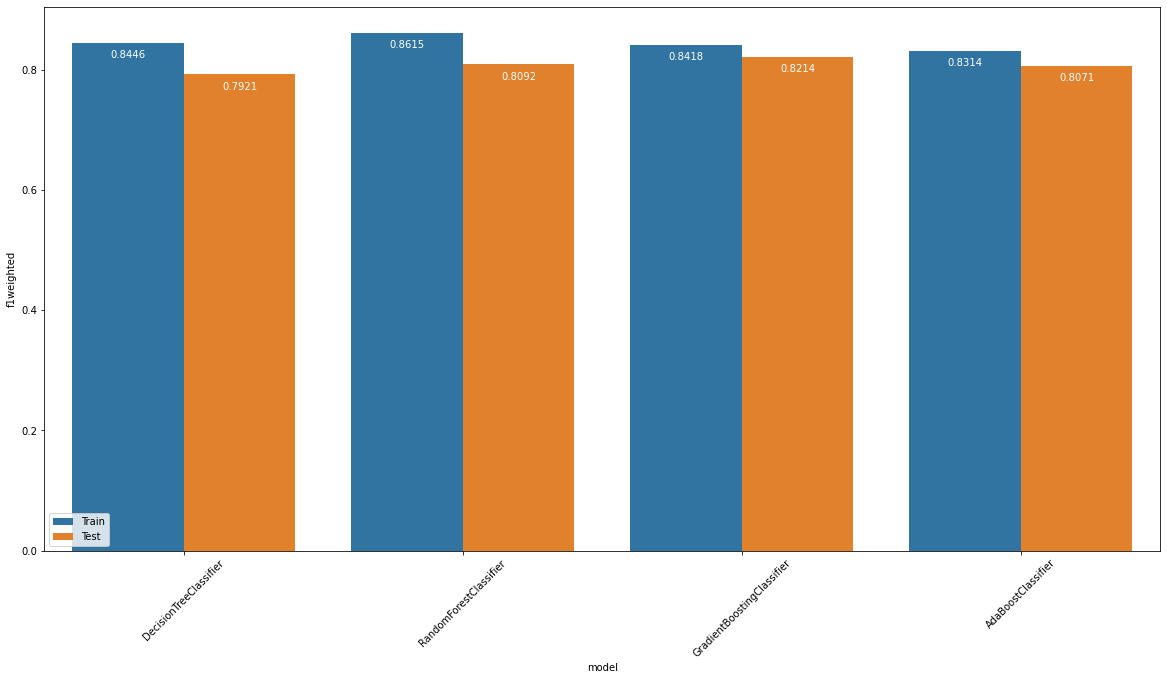

In [30]:
models = [modelTree,
          modelRF,
          modelGBC,
          modelAda
         ]

SMOTE_res = runModels(models,SMOTE_X_train,SMOTE_y_train,X_test,y_test)

### Using ADASYN to rebalance dataset

In [31]:
oversample = ADASYN()
ADASYN_X_train, ADASYN_y_train = oversample.fit_resample(X_train, y_train)
counter = Counter(ADASYN_y_train)
print(counter)

Counter({0: 8233, 1: 7860})


Running Model: DecisionTreeClassifier
-- Done. Duration: 0.354205846786499 s
Running Model: RandomForestClassifier
-- Done. Duration: 8.237670421600342 s
Running Model: GradientBoostingClassifier
-- Done. Duration: 7.88787055015564 s
Running Model: AdaBoostClassifier
-- Done. Duration: 3.2259488105773926 s
GLOBAL DURATION: 19.70664119720459 s


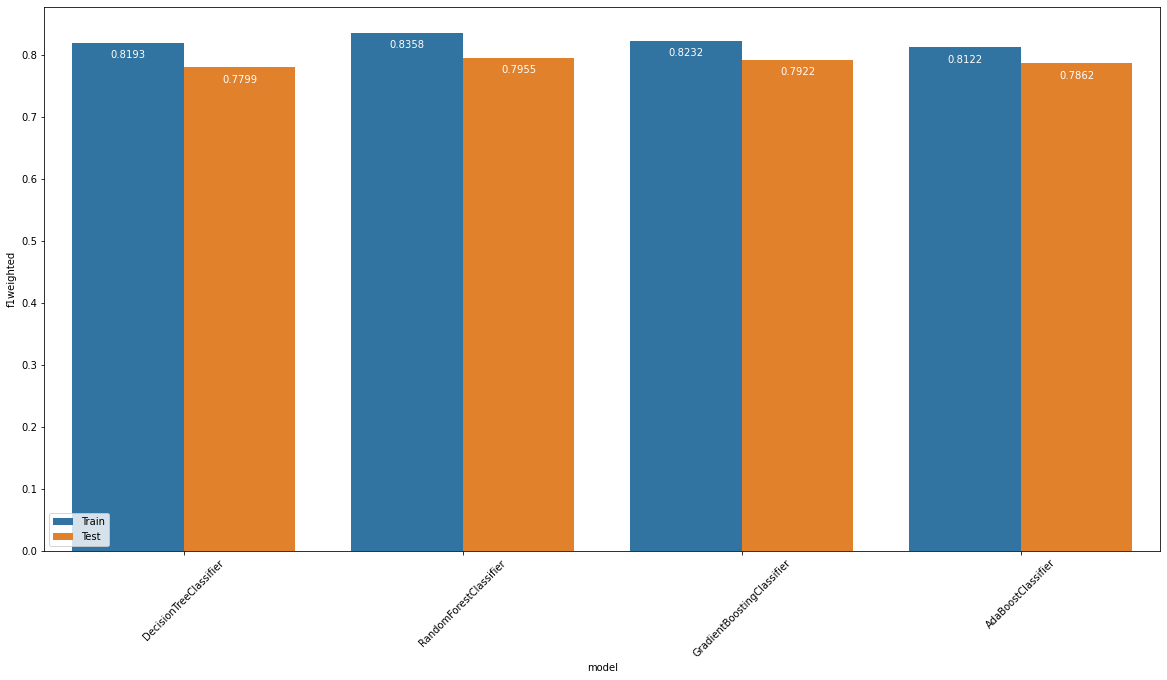

In [32]:
models = [modelTree,
          modelRF,
          modelGBC,
          modelAda
         ]

ADASYN_res = runModels(models,ADASYN_X_train,ADASYN_y_train,X_test,y_test)

### Using Random Under Sampler

In [33]:
RUS = RandomUnderSampler()
RUS_X_train, RUS_y_train = RUS.fit_resample(X_train, y_train)

counter = Counter(RUS_y_train)
print(counter)

Counter({0: 2734, 1: 2734})


Running Model: DecisionTreeClassifier
-- Done. Duration: 0.1380770206451416 s
Running Model: RandomForestClassifier
-- Done. Duration: 3.607830047607422 s
Running Model: GradientBoostingClassifier
-- Done. Duration: 3.148148775100708 s
Running Model: AdaBoostClassifier
-- Done. Duration: 1.4538774490356445 s
GLOBAL DURATION: 8.347933292388916 s


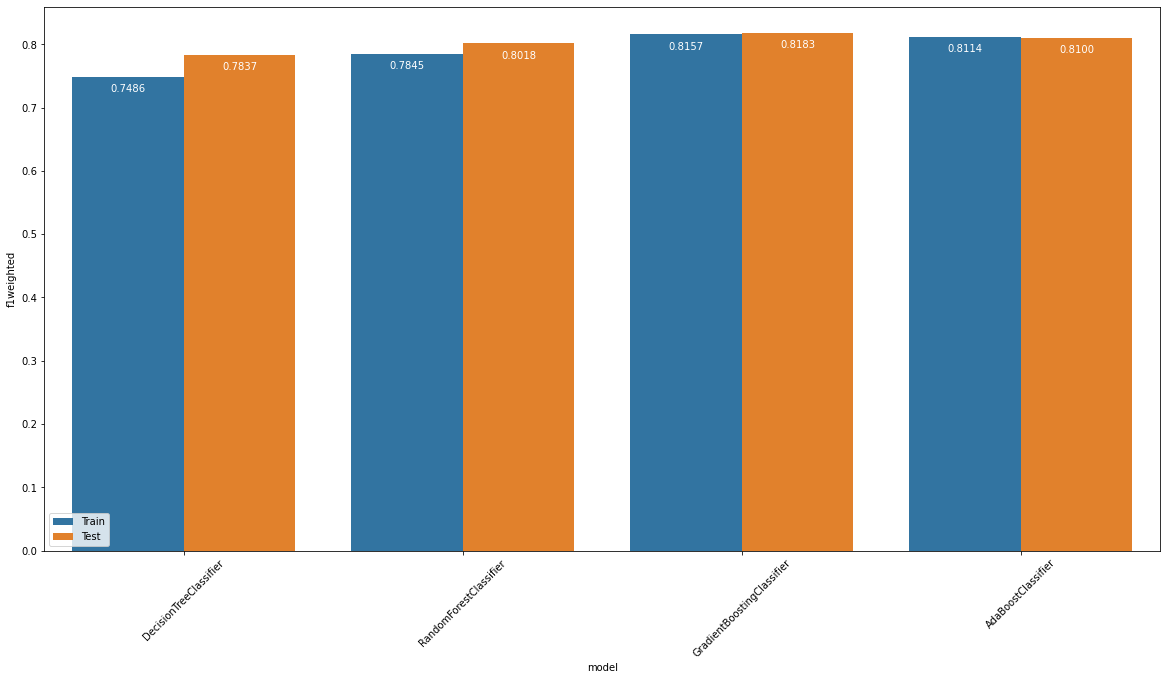

In [34]:
models = [modelTree,
          modelRF,
          modelGBC,
          modelAda
         ]

RUS_res = runModels(models,RUS_X_train,RUS_y_train,X_test,y_test)

### Using Tomek Links to undersample data

In [35]:
from imblearn.under_sampling import TomekLinks

TKL = TomekLinks()
TKL_X_train, TKL_y_train = TKL.fit_resample(X_train, y_train)

counter = Counter(TKL_y_train)
print(counter)

Counter({0: 8090, 1: 2734})


Running Model: DecisionTreeClassifier
-- Done. Duration: 0.2369849681854248 s
Running Model: RandomForestClassifier
-- Done. Duration: 5.871633052825928 s
Running Model: GradientBoostingClassifier
-- Done. Duration: 5.871744155883789 s
Running Model: AdaBoostClassifier
-- Done. Duration: 2.332911729812622 s
GLOBAL DURATION: 14.313968181610107 s


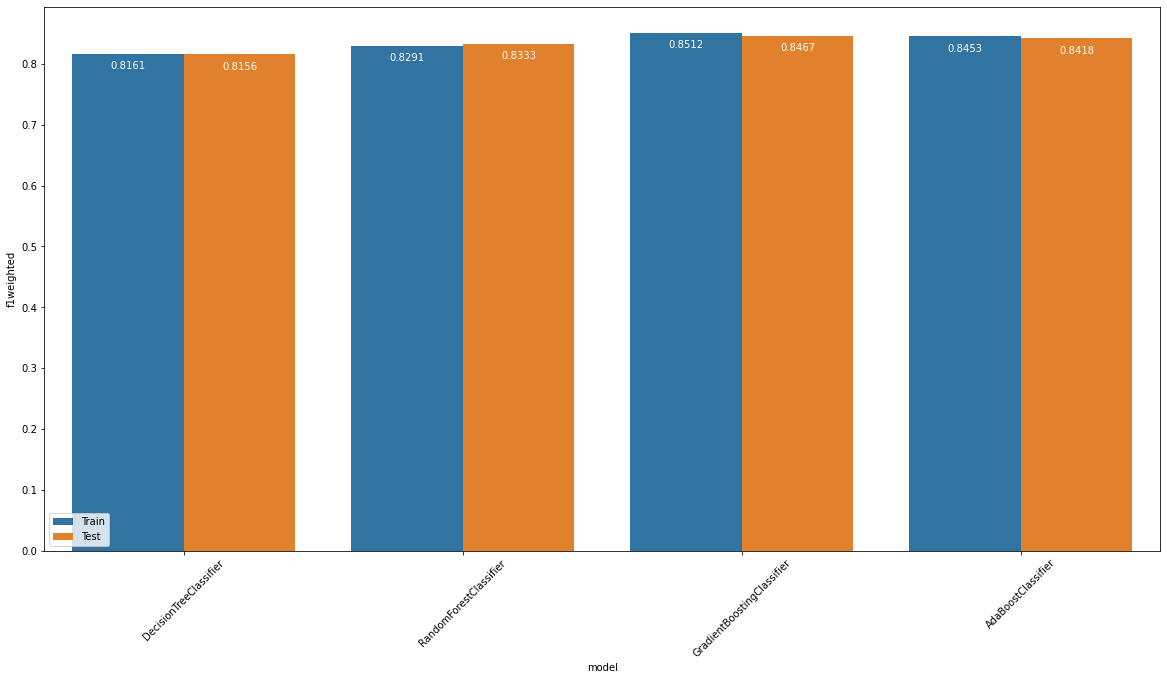

In [36]:
models = [modelTree,
          modelRF,
          modelGBC,
          modelAda
         ]

TKL_res = runModels(models,TKL_X_train,TKL_y_train,X_test,y_test)

### Using NearMiss to undersample data

In [37]:
from imblearn.under_sampling import AllKNN

NM = AllKNN()
NM_X_train, NM_y_train = NM.fit_resample(X_train, y_train)

counter = Counter(NM_y_train)
print(counter)

Counter({0: 6625, 1: 2734})


Running Model: DecisionTreeClassifier
-- Done. Duration: 0.20032906532287598 s
Running Model: RandomForestClassifier
-- Done. Duration: 4.960052013397217 s
Running Model: GradientBoostingClassifier
-- Done. Duration: 5.0285964012146 s
Running Model: AdaBoostClassifier
-- Done. Duration: 2.205390691757202 s
GLOBAL DURATION: 12.395362377166748 s


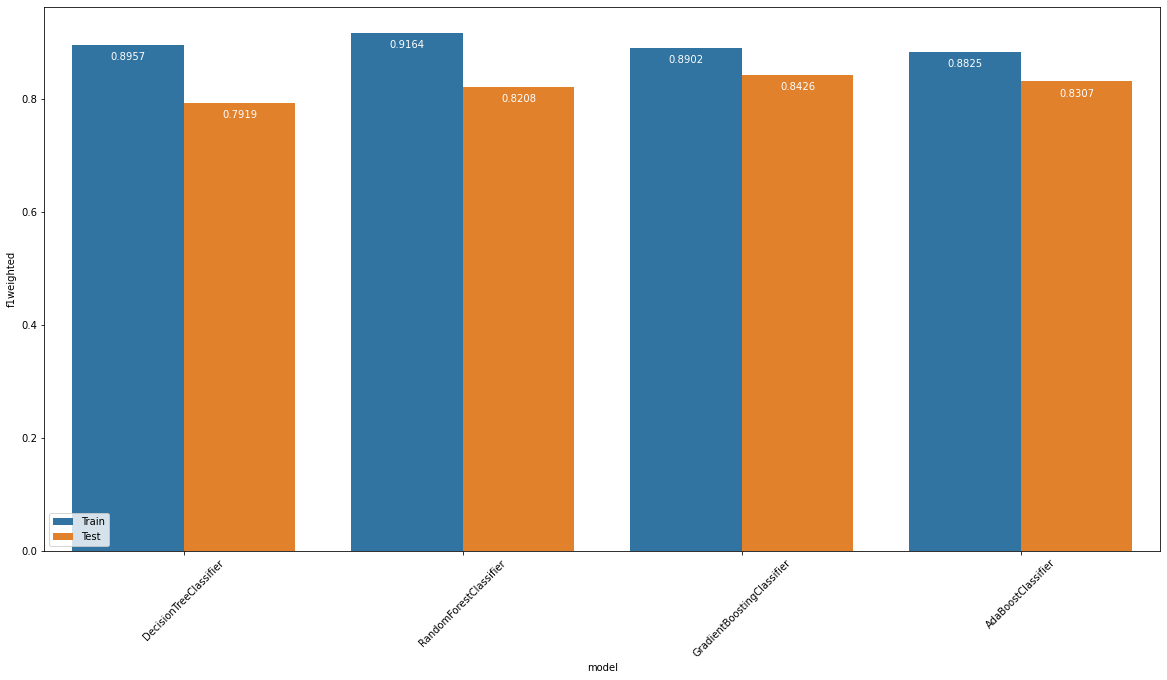

In [38]:
models = [modelTree,
          modelRF,
          modelGBC,
          modelAda
         ]

NM_res = runModels(models,NM_X_train,NM_y_train,X_test,y_test)

### Choose 1 method

In [39]:
X_train = TKL_X_train
y_train = TKL_y_train

## Data Scaling

### StandardScaler

In [40]:
scaler = StandardScaler()
SScale_X_train = scaler.fit_transform(X_train)
SScale_X_test = scaler.fit_transform(X_test)
SScale_y_train = y_train
SScale_y_test = y_test

Running Model: DecisionTreeClassifier
-- Done. Duration: 0.2146759033203125 s
Running Model: RandomForestClassifier
-- Done. Duration: 5.976827383041382 s
Running Model: GradientBoostingClassifier
-- Done. Duration: 6.375828981399536 s
Running Model: AdaBoostClassifier
-- Done. Duration: 2.5943944454193115 s
GLOBAL DURATION: 15.161726713180542 s


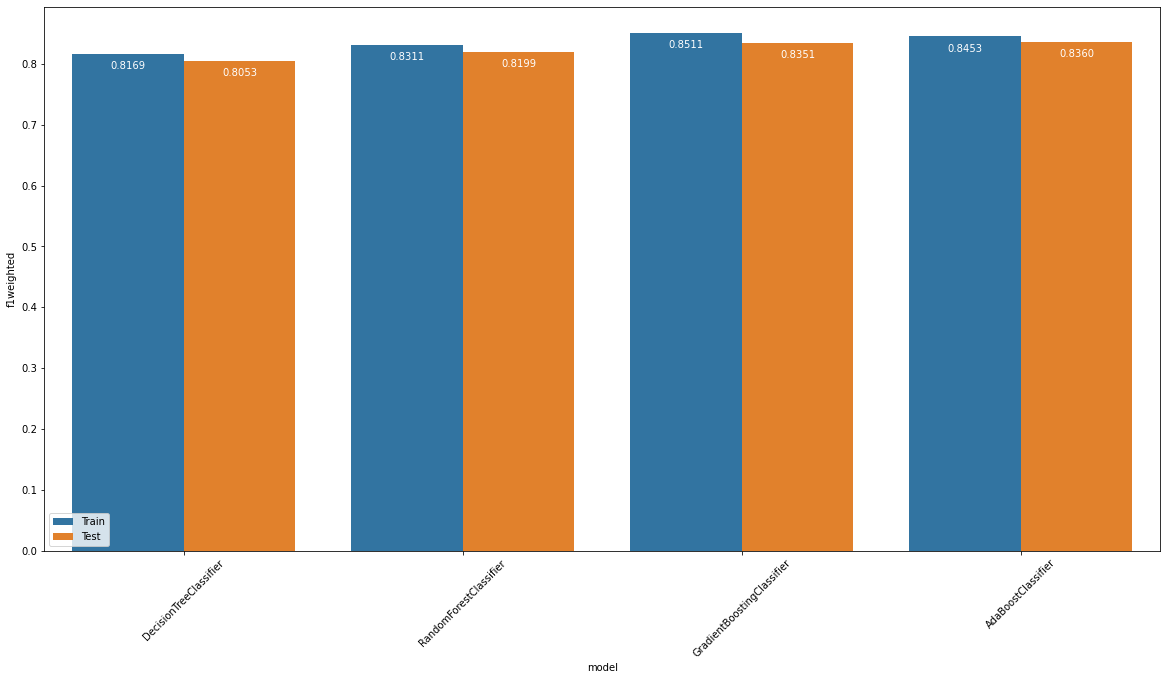

In [41]:
models = [modelTree,
          modelRF,
          modelGBC,
          modelAda
         ]

SScaler_res = runModels(models,SScale_X_train,SScale_y_train,SScale_X_test,SScale_y_test)

### MinMax 0:1

In [42]:
scaler = MinMaxScaler(feature_range=(0, 1))
MinMaxScaler_01_X_train = scaler.fit_transform(X_train)
MinMaxScaler_01_X_test = scaler.fit_transform(X_test)
MinMaxScaler_01_y_train = y_train
MinMaxScaler_01_y_test = y_test

Running Model: DecisionTreeClassifier
-- Done. Duration: 0.21460366249084473 s
Running Model: RandomForestClassifier
-- Done. Duration: 5.968705177307129 s
Running Model: GradientBoostingClassifier
-- Done. Duration: 6.238968372344971 s
Running Model: AdaBoostClassifier
-- Done. Duration: 2.5724380016326904 s
GLOBAL DURATION: 14.995710134506226 s


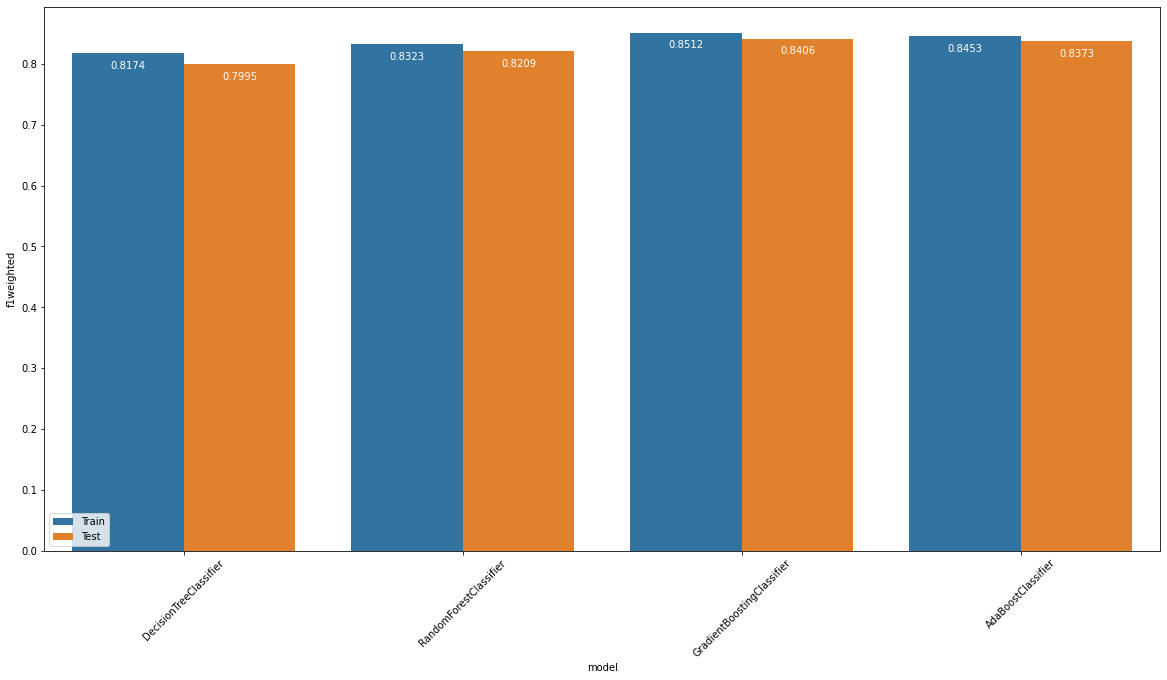

In [43]:
models = [modelTree,
          modelRF,
          modelGBC,
          modelAda
         ]

MinMaxScaler_01_res = runModels(models,MinMaxScaler_01_X_train,MinMaxScaler_01_y_train,MinMaxScaler_01_X_test,MinMaxScaler_01_y_test)

### MinMax -1:1

In [44]:
scaler = MinMaxScaler(feature_range=(-1, 1))
MinMaxScaler_11_X_train = scaler.fit_transform(X_train)
MinMaxScaler_11_X_test = scaler.fit_transform(X_test)
MinMaxScaler_11_y_train = y_train
MinMaxScaler_11_y_test = y_test

Running Model: DecisionTreeClassifier
-- Done. Duration: 0.22029662132263184 s
Running Model: RandomForestClassifier
-- Done. Duration: 6.05509877204895 s
Running Model: GradientBoostingClassifier
-- Done. Duration: 6.106394052505493 s
Running Model: AdaBoostClassifier
-- Done. Duration: 2.4787251949310303 s
GLOBAL DURATION: 14.862831115722656 s


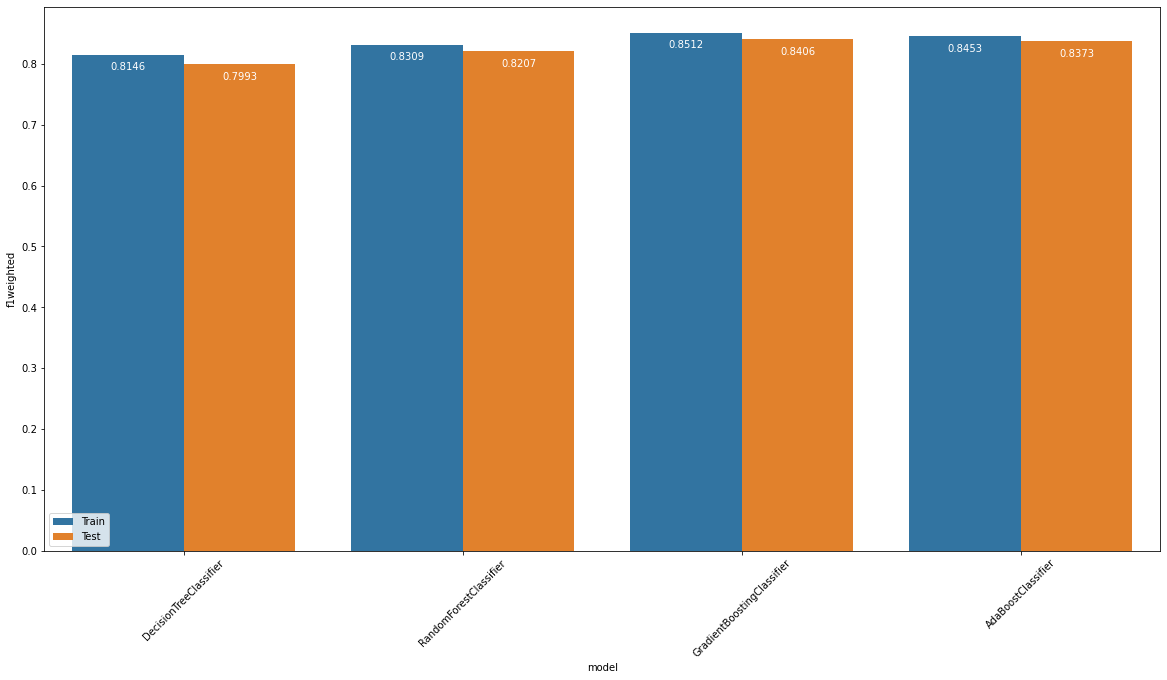

In [45]:
models = [modelTree,
          modelRF,
          modelGBC,
          modelAda
         ]

MinMaxScaler_11_res = runModels(models,MinMaxScaler_11_X_train,MinMaxScaler_11_y_train,MinMaxScaler_11_X_test,MinMaxScaler_11_y_test)

### RobustScaler

In [46]:
scaler = RobustScaler()
RobScaler_X_train = scaler.fit_transform(X_train)
RobScaler_X_test = scaler.fit_transform(X_test)
RobScaler_y_train = y_train
RobScaler_y_test = y_test

Running Model: DecisionTreeClassifier
-- Done. Duration: 0.22075128555297852 s
Running Model: RandomForestClassifier
-- Done. Duration: 6.024864673614502 s
Running Model: GradientBoostingClassifier
-- Done. Duration: 6.171440601348877 s
Running Model: AdaBoostClassifier
-- Done. Duration: 2.4061288833618164 s
GLOBAL DURATION: 14.823185443878174 s


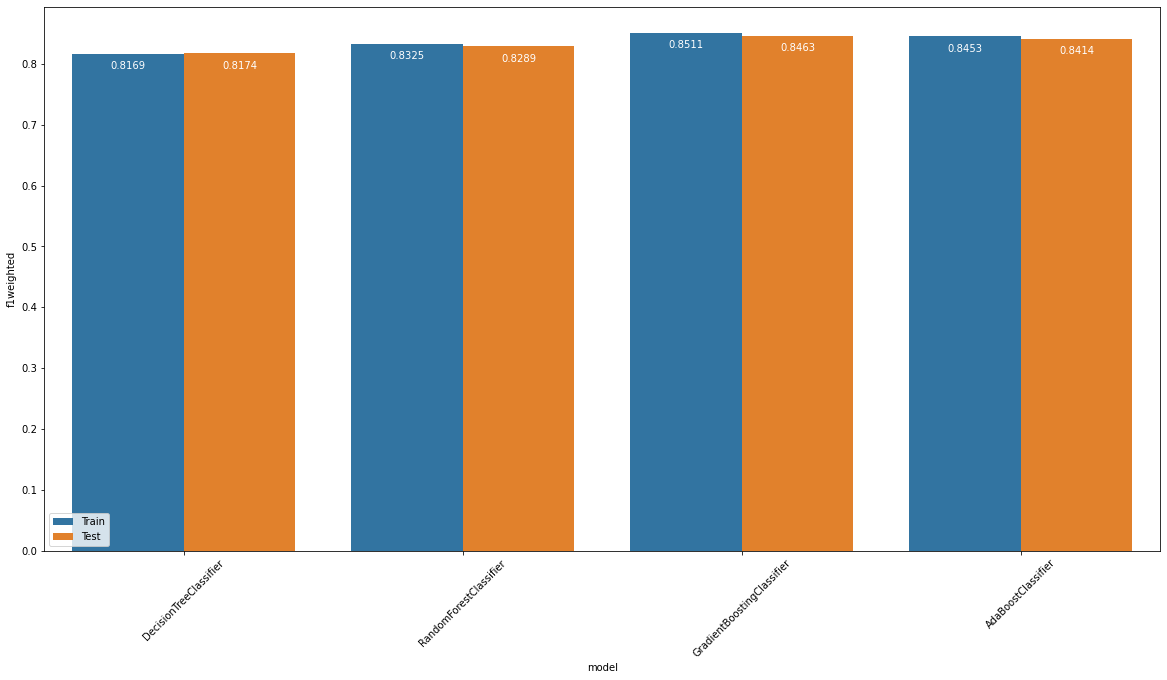

In [47]:
models = [modelTree,
          modelRF,
          modelGBC,
          modelAda
         ]

RobScaler_res = runModels(models,RobScaler_X_train,RobScaler_y_train,RobScaler_X_test,RobScaler_y_test)

## Feature Selection
In this section, we will eliminate noise from the model.

### Hyperpatameterization

## Produce File for Submission

In [48]:
# prepped_data_test = DataPreProcessing(data_test)
# prepped_data_test = AlignDataframe(optimizer_X_train.columns,prepped_data_test)

In [49]:
# predictions = model.predict(prepped_data_test)
# prepped_data_test['Income'] = predictions
# prepped_data_test[['Income']].to_csv('Group10_Version19.csv')